In [1]:
import os
import pandas as pd
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence

import glob
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import re

### Load the dataset

In [2]:
folder_path = 'Tidepool_Datasets/Tidepool-JDRF-HCL150-train/train-data'

# Regular expression pattern to match filenames (train_[a-f0-9]+.csv)
file_pattern = r'train_[a-f0-9]+\.csv'

# List all files in the folder
all_files = os.listdir(folder_path)

# Filter files matching the regular expression
csv_files = [f for f in all_files if re.match(file_pattern, f)]

### I will take only the first 1000 datapoint from each CSV file to use to train the model. The dataset is too large to be used in its entirety. 

In [3]:
# Initialize a list to hold the data for all subjects
all_data = []

# Iterate over each file
for file in csv_files:
    # Construct the full file path
    file_path = os.path.join(folder_path, file)
    
    # Read the CSV file
    data = pd.read_csv(file_path, low_memory=False)
    
    # Filter the data to only include rows where 'type' is 'cbg'
    cbg_data = data[data['type'] == 'cbg'].copy()  # Ensure it's a copy
    
    # Ensure the 'time' column is in datetime format (removing deprecated argument)
    cbg_data.loc[:, 'time'] = pd.to_datetime(cbg_data['time'], errors='coerce') 
    
    # Drop rows where 'time' could not be parsed or 'value' is missing
    cbg_data = cbg_data.dropna(subset=['time', 'value'])
    
    # Sort by time (just in case they are not in order)
    cbg_data = cbg_data.sort_values(by='time')
    
    # Select the first 1000 rows
    cbg_data = cbg_data.head(1000)
    
    # Append to the list of all data
    all_data.append(cbg_data[['time', 'value']])

### Plot all the subjects' glucose levels on the same graph to get a sense of how similar they are. X-axis is datapoint steps.

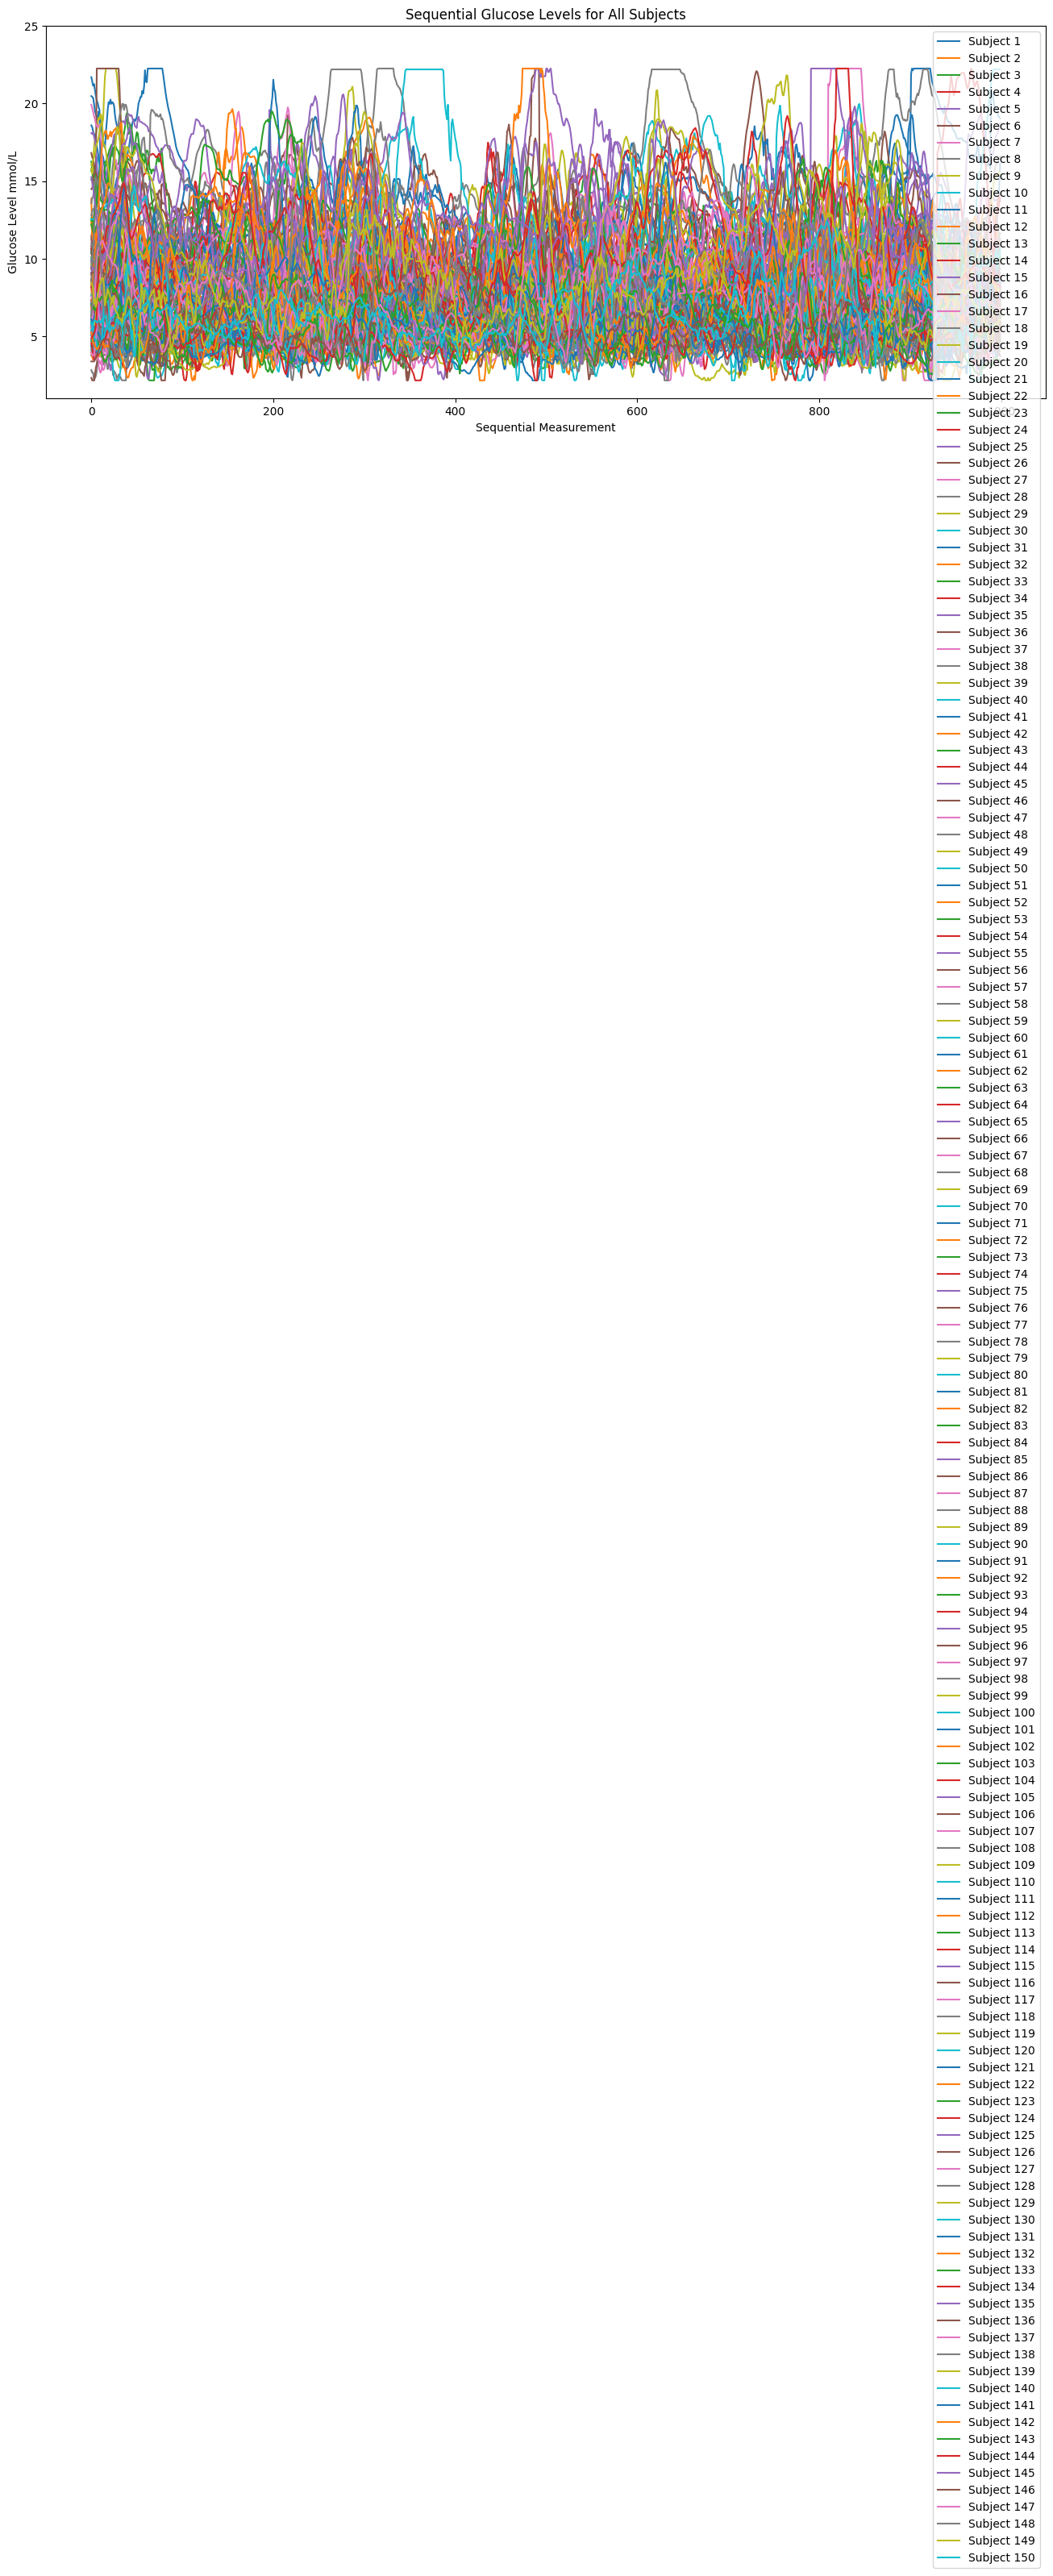

In [4]:
# Plot glucose levels for all subjects sequentially
plt.figure(figsize=(16, 6))

# Iterate through each subject's data and plot sequentially using the index
for i, data in enumerate(all_data):
    plt.plot(data['value'].reset_index(drop=True), label=f'Subject {i+1}')

plt.ylim(1, 25)
plt.xlabel('Sequential Measurement')
plt.ylabel('Glucose Level mmol/L')
plt.title('Sequential Glucose Levels for All Subjects')
plt.legend(loc='upper right')
plt.show()

### Standardize the data with MinMax scaling

In [6]:
# Concatenate all the data
combined_data = pd.concat(all_data)

# Convert the 'value' column to a numpy array
glucose_values = combined_data['value'].values

# Reshape the data for MinMax scaling
glucose_values = glucose_values.reshape(-1, 1)

# Normalize the glucose values between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
glucose_values_scaled = scaler.fit_transform(glucose_values)

### Create the dataset on the combined model, using timesteps as the X-axis. Create a 80:20 train-test split.

In [7]:
# Create the X and y data components from all the combined and scaled dataset
def create_dataset(data, time_step=10):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Create the dataset with a time step of 10 (this hyperparameter is adjustable)
time_step = 10
X, y = create_dataset(glucose_values_scaled, time_step)

# Reshape the input to be [samples, time steps, features] for LSTM
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split the data into training and testing sets (e.g., 80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

### Define the LSTM model

In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2])),
    tf.keras.layers.LSTM(units=100, return_sequences=True, input_shape=(time_step, 1)),
    tf.keras.layers.LSTM(units=100, return_sequences=False),
    tf.keras.layers.Dense(units=25),
    tf.keras.layers.Dense(units=1)
])

### Compile model and start training

In [11]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, batch_size=32, epochs=10)

Epoch 1/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 66s 17ms/step - loss: 0.0020
Epoch 2/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 64s 17ms/step - loss: 2.6599e-04
Epoch 3/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 64s 17ms/step - loss: 2.5983e-04
Epoch 4/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 59s 16ms/step - loss: 2.4989e-04
Epoch 5/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 63s 17ms/step - loss: 2.5427e-04
Epoch 6/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 65s 17ms/step - loss: 2.5519e-04
Epoch 7/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 65s 17ms/step - loss: 2.3803e-04
Epoch 8/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 62s 16ms/step - loss: 2.7665e-04
Epoch 9/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 67s 18ms/step - loss: 2.5166e-04
Epoch 10/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 66s 18ms/step - loss: 2.4447e-04


### Make predictions

In [12]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

3750/3750 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step


### Un-normalize the predictions and actual data

In [13]:
# Inverse transform predictions back to original scale
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Inverse transform the actual values
y_train_actual = scaler.inverse_transform([y_train])
y_test_actual = scaler.inverse_transform([y_test])

### Plot the results – actual vs predicted data

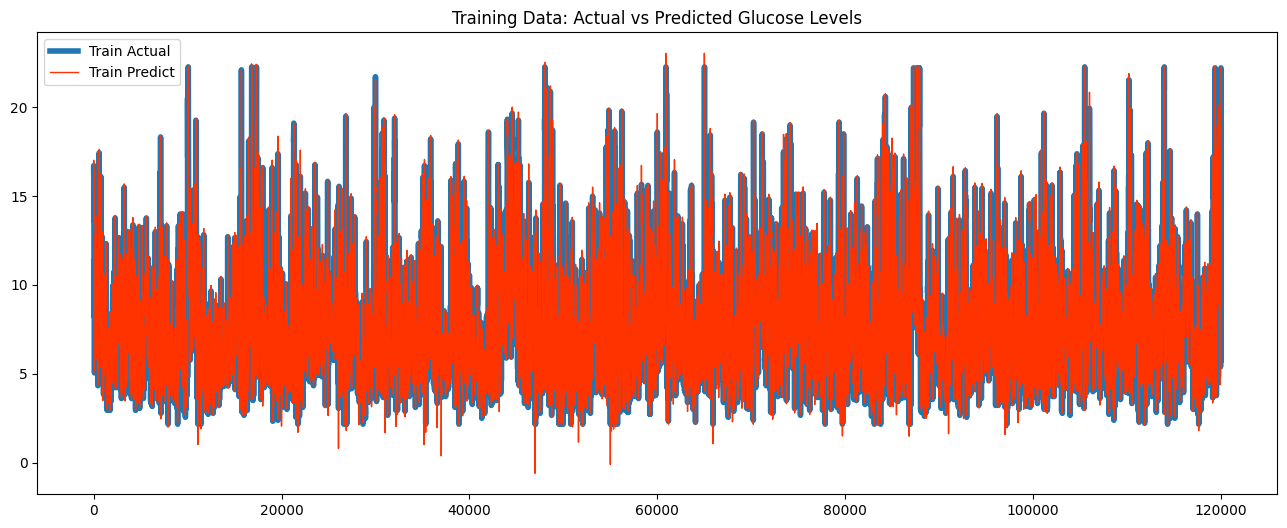

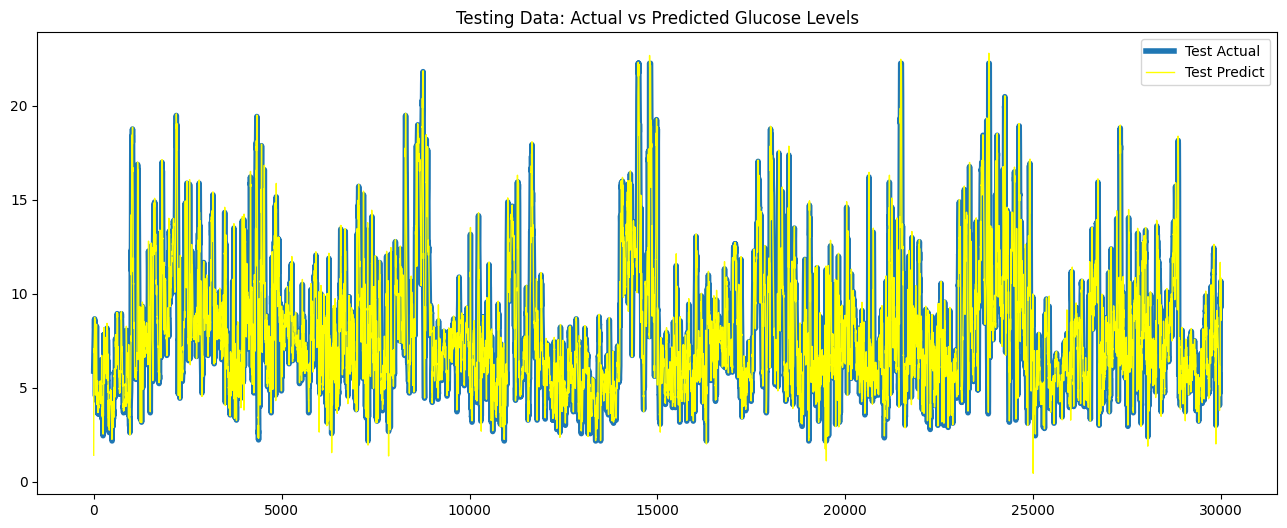

In [14]:
# Plot the predictions vs actual glucose levels
plt.figure(figsize=(16, 6))
plt.plot(range(len(y_train_actual[0])), y_train_actual[0], label='Train Actual', linewidth=4)
plt.plot(range(len(train_predict)), train_predict, label='Train Predict', linewidth=1, color='#ff3300')
plt.legend()
plt.title("Training Data: Actual vs Predicted Glucose Levels")
plt.show()

plt.figure(figsize=(16, 6))
plt.plot(range(len(y_test_actual[0])), y_test_actual[0], label='Test Actual', linewidth=4)
plt.plot(range(len(test_predict)), test_predict, label='Test Predict', color='yellow', linewidth=1)
plt.legend()
plt.title("Testing Data: Actual vs Predicted Glucose Levels")
plt.show()

In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_test = y_test_actual.reshape(-1)
y_pred = test_predict.reshape(-1)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculate R^2 score (Coefficient of Determination)
r2 = r2_score(y_test, y_pred)
print(f"R^2 Score: {r2}")

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

Mean Absolute Error (MAE): 0.16480614582387784
Mean Squared Error (MSE): 0.09274545384895011
Root Mean Squared Error (RMSE): 0.30454138281841125
R^2 Score: 0.9912958906476043
Mean Absolute Percentage Error (MAPE): 2.352084436011213%
